# Fold a power law spectra through the MagEIS isotropic response functions 

This notebook explores the Bayes appoach to estimate a given exponential spectra that is folded through the MagEIS LOW's isotropic response functions (energy-dependent geometric factors)

In [101]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [102]:
# Spectra parameters
nt = -2 # Unitless
at = 5E6 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP MagEIS LOW.
E = R.E*1000 # Energy channel array in keV.
n_ch = 15

# Define an exponential spectra.
def spectra(Earr, a, n):
    return a*Earr**n

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch)
for i in range(n_ch):
    true_lambda[i] = scipy.integrate.trapz(spectra(E, at, nt)*R.response(i), x=E)

Since pymc3 does not natively do integrationm, now I code in my own trapezium integrator and check against the above values (to make it compatable with pymc3).

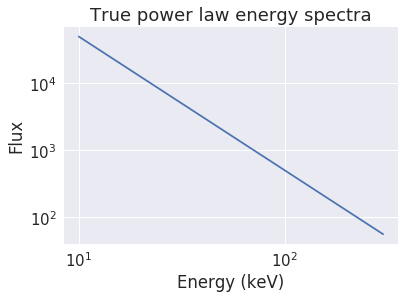

In [103]:
plt.loglog(E, spectra(E, at, nt)); plt.title('True power law energy spectra')
plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

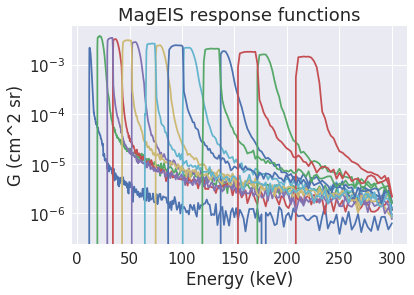

In [104]:
for i in range(n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');

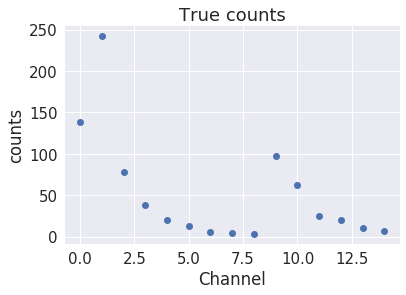

In [105]:
plt.plot(range(n_ch), true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [106]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

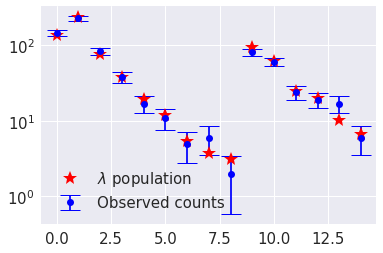

In [107]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed counts', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(n_ch), true_lambda, 'r*', ms=15, label=r'$\lambda$ population')
plt.yscale('log'); plt.legend();

In [108]:
m = pm.Model()

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[None]
    for i in range(len(c_obs)):
        f = JJ*R.response(i)
        lams[i] = pm.Deterministic(
            'lam{}'.format(i), 0.5*pm.math.sum((f[1:]+f[:-1])*(E[1:] - E[:-1])))
    return lams

with m:
    # Prior stocastic variables
    n = pm.Uniform('n', lower=-10, upper=-1)
    a = pm.Uniform('a', lower=0, upper=1E7)
    
    # Define an exponential spectra
    J = spectra(E, a, n)
    
    lams = lam(J)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=5000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a_interval__, n_interval__]
100%|██████████| 10500/10500.0 [00:55<00:00, 190.89it/s]
The acceptance probability does not match the target. It is 0.8890462900326196, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


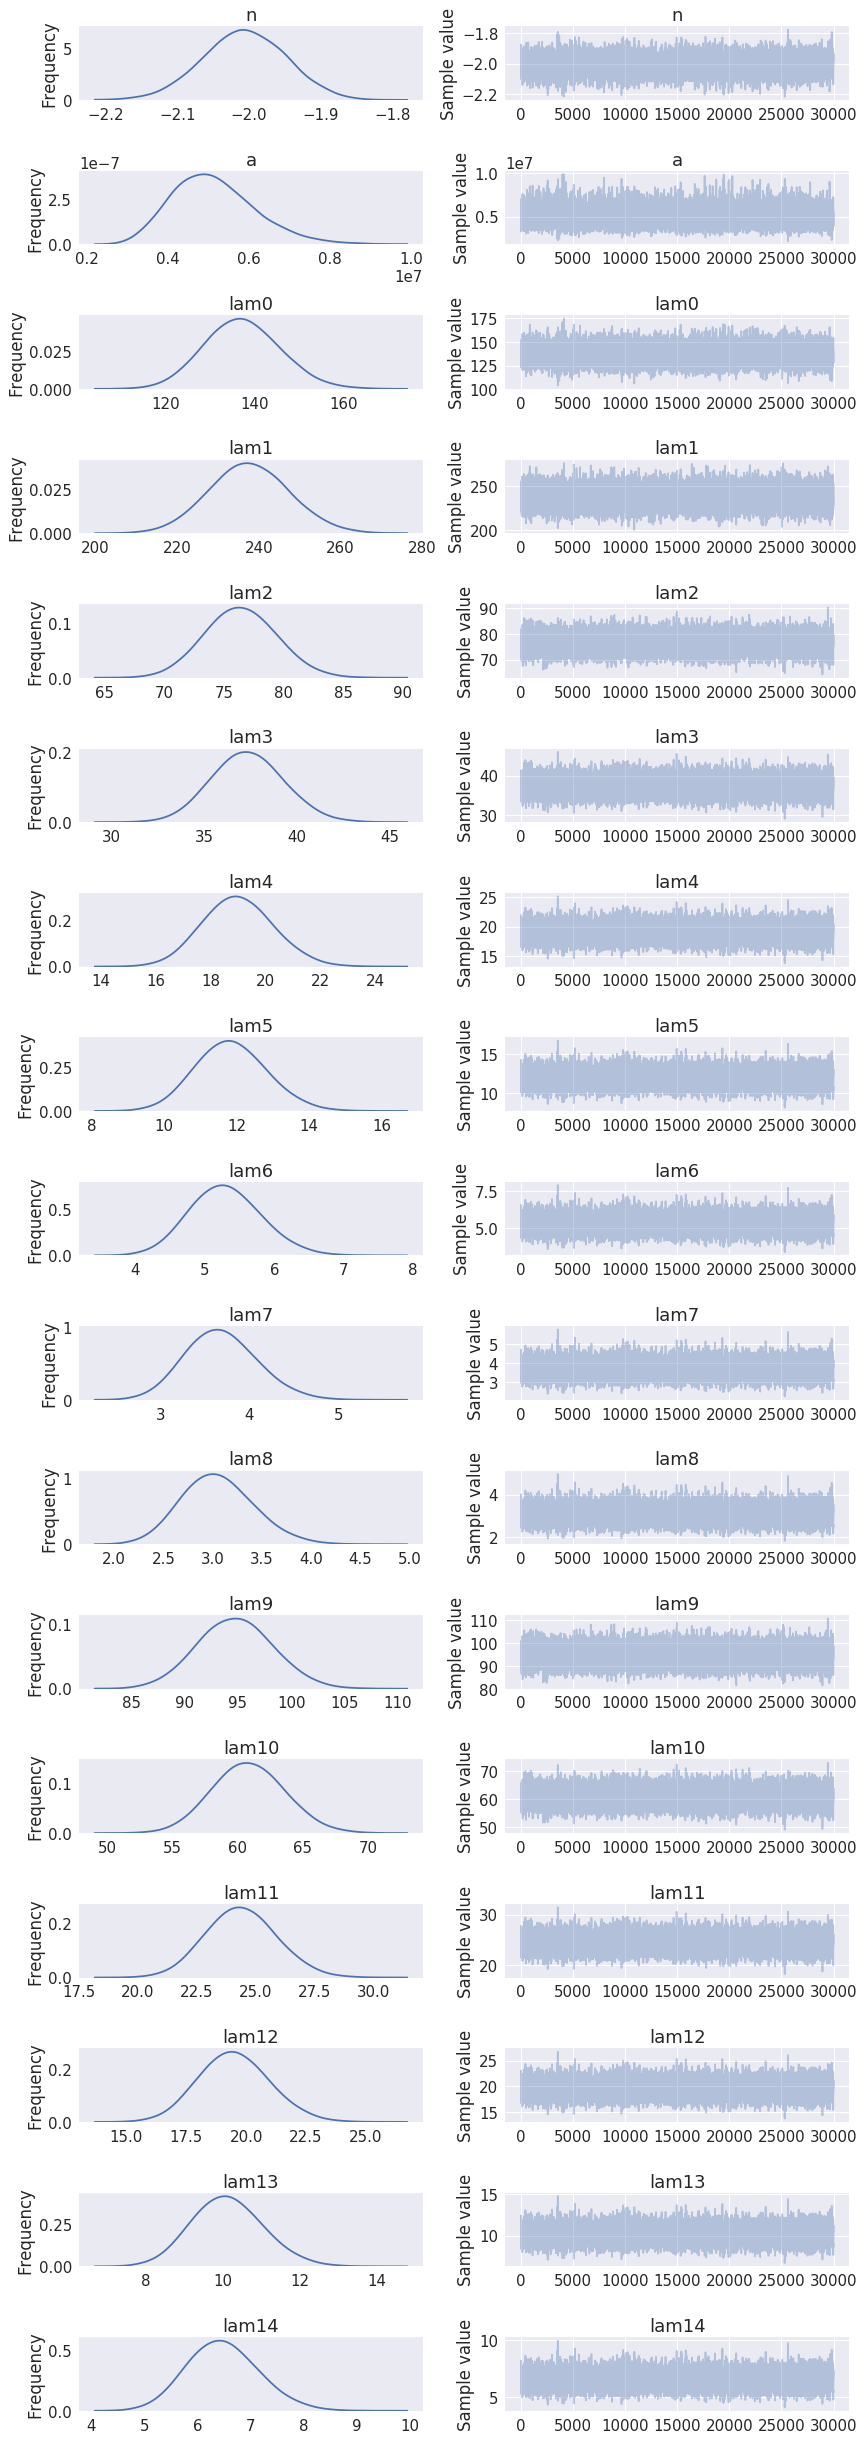

In [109]:
pm.traceplot(trace, combined=True);

In [110]:
pm.summary(trace)

mean            sd      mc_error       hpd_2.5      hpd_97.5  \
n     -2.007408e+00  5.756305e-02      0.000805 -2.117204e+00 -1.892832e+00   
a      5.121727e+06  1.038823e+06  15632.304395  3.222742e+06  7.156049e+06   
lam0   1.370303e+02  8.414078e+00      0.112659  1.206427e+02  1.534962e+02   
lam1   2.375700e+02  9.700113e+00      0.097570  2.184130e+02  2.564048e+02   
lam2   7.637523e+01  2.972950e+00      0.019301  7.072158e+01  8.230650e+01   
lam3   3.731008e+01  1.918659e+00      0.017639  3.357816e+01  4.105053e+01   
lam4   1.897863e+01  1.269197e+00      0.013705  1.657149e+01  2.152188e+01   
lam5   1.184021e+01  9.671615e-01      0.011179  9.962428e+00  1.374110e+01   
lam6   5.287624e+00  5.097041e-01      0.006112  4.317066e+00  6.309748e+00   
lam7   3.678883e+00  4.000581e-01      0.004890  2.902613e+00  4.463047e+00   
lam8   3.046509e+00  3.635778e-01      0.004495  2.356278e+00  3.774590e+00   
lam9   9.469186e+01  3.506260e+00      0.023298  8.778136e+01  1.014924e+02   
lam10  6.080175e+01  2.742817e+00      0.021989  5.541587e+01  6.611537e+01   
lam11  2.437624e+01  1.483346e+00      0.015304  2.155479e+01  2.732935e+01   
lam12  1.947789e+01  1.457840e+00      0.016420  1.678249e+01  2.248075e+01   
lam13  1.010745e+01  9.180155e-01      0.010881  8.361051e+00  1.194582e+01   
lam14  6.474178e+00  6.692529e-01      0.008120  5.196841e+00  7.808932e+00   

              n_eff      Rhat  
n       5598.890035  1.000022  
a       5149.376894  1.000003  
lam0    6978.164394  0.999996  
lam1   13220.872609  0.999968  
lam2   21346.571136  0.999955  
lam3   10583.678360  0.999980  
lam4    8067.791849  0.999997  
lam5    7211.266335  1.000007  
lam6    6789.046891  1.000014  
lam7    6577.021112  1.000018  
lam8    6451.477272  1.000022  
lam9   25268.723997  0.999951  
lam10  13435.994659  0.999969  
lam11   8704.001794  0.999992  
lam12   7524.312647  1.000003  
lam13   6920.131101  1.000011  
lam14   6658.453604  1.000016

In [111]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

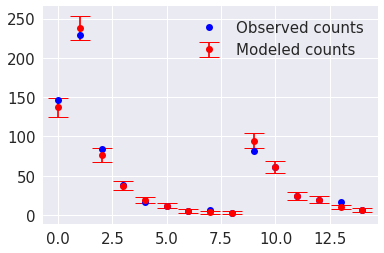

In [112]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_mean, yerr=np.sqrt(c_mean), 
                            c='r', fmt='o', capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(len(c_obs)), c_obs, 'bo', label='Observed counts'); 
plt.legend();

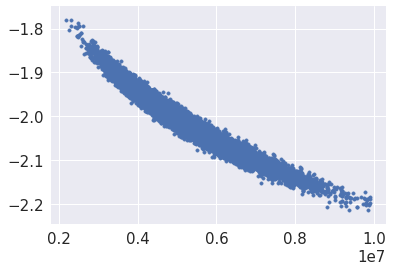

In [113]:
plt.scatter(trace['a'], trace['n'], marker='.');

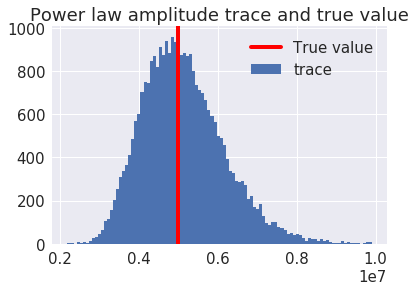

In [114]:
plt.hist(trace['a'], bins=100, label='trace')
plt.axvline(at, c='r', lw=4, label='True value');
plt.legend(); plt.title('Power law amplitude trace and true value');

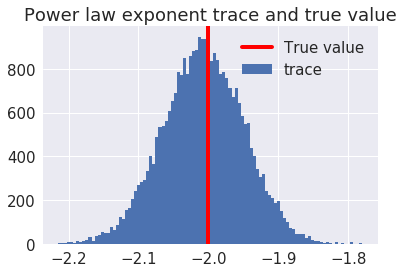

In [115]:
plt.hist(trace['n'], bins=100, label='trace')
plt.axvline(nt, c='r', lw=4, label='True value');
plt.legend(); plt.title('Power law exponent trace and true value');

## Posterior post predictive checks
Here we draw samples from the posterior distribution and check if the calculated counts from the picked E0 and J0 values are consistant with the data. Essentialy, we are looking to see if the observed counts are inside the drawn posterior distribution. 

In [116]:
ppc = pm.sample_ppc(trace, samples=5000, model=m)

100%|██████████| 5000/5000 [00:06<00:00, 813.02it/s]


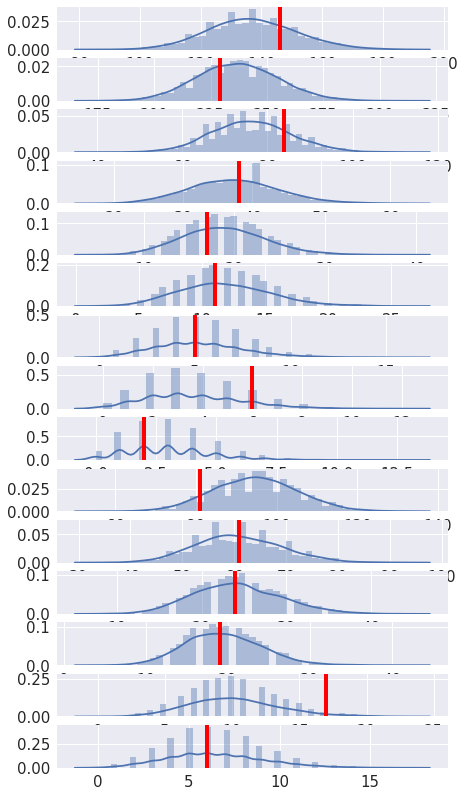

In [117]:
fig, ax = plt.subplots(len(c_obs),1, figsize=(7,14))
for i in range(len(c_obs)):
    sns.distplot(ppc['c_m'][:,i], ax=ax[i])
    ax[i].axvline(c_obs[i], c='r', lw=4)

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [118]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
dist = np.zeros((len(E), nS), dtype=float)
for (i, s) in enumerate(random_samples):
    for e in range(len(E)):
        dist[e, i] = spectra(E, trace['a'][s], trace['n'][s])[e]

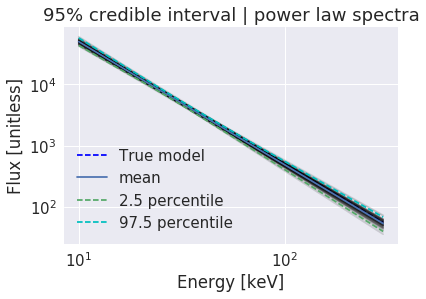

In [119]:
plt.loglog(E, spectra(E, at, nt), 'b--', label='True model')
for i in random_samples:
    plt.plot(E, spectra(E, trace['a'][i], trace['n'][i]), c='k', alpha=0.07)
plt.plot(E, np.mean(dist, axis=1), label='mean');
plt.plot(E, np.percentile(dist, 2.5, axis=1), '--', label='2.5 percentile')
plt.plot(E, np.percentile(dist, 97.5, axis=1), '--', label='97.5 percentile', c='c')
plt.legend(); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | power law spectra');